In [1]:
import os
import random
from PIL import Image
from tabulate import tabulate

# Reading the database

You can download the database here:

- [https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip](https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip)
- [ipfs://QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr](ipfs://QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr)
- [https://ipfs.prgm.dev/ipfs/QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr](https://ipfs.prgm.dev/ipfs/QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr)

Shasum (.zip): `8ba107bf1dbd7864865260d3eb8f07580646cb8c` 

In [2]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

## Database header
The first 30 bytes of the database are reserved for a header which currently contains **three** 4-byte int: 
1. The number of machines that are undecided because they went beyond the time limit (`47,176,870` steps)
2. The number of machines that are undecided because they went beyond the space limit (`12,289` memory cells)
3. The total number of undecided machines (sum of above)

In [3]:
def get_header(machine_db_path):
    with open(machine_db_path, "rb") as f:
        return f.read(30)

In [4]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),int.from_bytes(header[8:12],byteorder='big')
print(undecided_time, undecided_space, undecided_total)

14322029 74342035 88664064


## Database core

The core of the database is `88,664,064` machines descriptions which are each written on 30 bytes.

In [5]:
n = os.path.getsize(DB_PATH)
print((n)/30-1)

88664064.0


In [6]:
def get_machine_i(machine_db_path, i, db_has_header=True):
    with open(machine_db_path, "rb") as f:
        c = 1 if db_has_header else 0
        f.seek(30*(i+c))
        return f.read(30)

In [7]:
def ithl(i):
    return chr(ord("A")+i)

def g(move):
    if move == 0:
        return "R"
    return "L"

def pptm(machine, return_repr=False):
    headers = ["s","0","1"]
    table = []
    
    for i in range(5):
        row = [ithl(i)]
        for j in range(2):
            write = machine[6*i+3*j] 
            move = machine[6*i+3*j+1] 
            goto = machine[6*i+3*j+2]-1
            
            if goto == -1:
                row.append("???")
                continue
                
            row.append(f"{write}{g(move)}{ithl(goto)}")
        table.append(row)
    
    if not return_repr:
        print(tabulate(table,headers=headers))
    else:
        return tabulate(table,headers=headers)

In [8]:
pptm(get_machine_i(DB_PATH,0,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  1LA
B    0LA  1RC
C    1RA  0RD
D    ???  0LE
E    1RA  ???


In [9]:
pptm(get_machine_i(DB_PATH,10,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  1LA
B    0LA  1LC
C    0RD  0RB
D    0RE  0RC
E    0LD  ???


In [10]:
pptm(get_machine_i(DB_PATH,4888230,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  0LC
B    0RC  0LE
C    1LD  0RD
D    1LB  0RA
E    1LC  ???


# Simulating and visualising machines

In [11]:
def step(machine, curr_state, curr_pos, tape):
    if not curr_pos in tape:
        tape[curr_pos] = 0
    
    write = machine[curr_state*6 + 3*tape[curr_pos]] 
    move = machine[curr_state*6 + 3*tape[curr_pos] + 1] 
    goto = machine[curr_state*6 + 3*tape[curr_pos] + 2] - 1

    if goto == -1:
        return None, None
    
    tape[curr_pos] = write
    next_pos = curr_pos  + (-1 if move else 1)
    return goto, next_pos

In [12]:
def simulate(machine, time_limit = 1000, mini =-10, maxi=-10):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    while curr_state != None and curr_time < time_limit:
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        if curr_state is not None:
            pprinttape(tape, curr_state, curr_pos, mini=mini, maxi=maxi)
        else:
            print("HALT")
        curr_time += 1
        

In [13]:
def tm_trace_to_image(machine, width=900, height=1000, origin=0.5, show_head_direction=False):
    img = Image.new('RGB', (width, height), color = 'black')
    pixels = img.load()
    
    
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    
    for row in range(1,height):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        
        if curr_state is None: #halt
            return img
        
        for col in range(width):
            pos = col-width*(origin)
            
            if pos in tape:
                pixels[col,row] = (255,255,255) if tape[pos] == 1 else (0,0,0)
                #pixels[col,row-1] = colors[curr_state-1]
                
            if pos == curr_pos and show_head_direction:
                pixels[col,row] = (255,0,0) if curr_pos > last_pos else (0,255,0) 
                
                
    #img = zoom_at(img,*zoom)
    return img

In [14]:
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)

## BB(5) champion

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [15]:
def repr_to_bytes(rep):
    to_rep = bytearray()
    for a in rep:
        to_rep.append(a)
    return to_rep

R, L = 0, 1
bb5_champion_repr = [1, R, 2, 1, L, 3,
		1, R, 3, 1, R, 2,
		1, R, 4, 0, L, 5,
		1, L, 1, 1, L, 4,
		1, R, 6, 0, L, 1]
bb5_champion = repr_to_bytes(bb5_champion_repr)
pptm(bb5_champion)

s    0    1
---  ---  ---
A    1RB  1LC
B    1RC  1RB
C    1RD  0LE
D    1LA  1LD
E    1RF  0LA


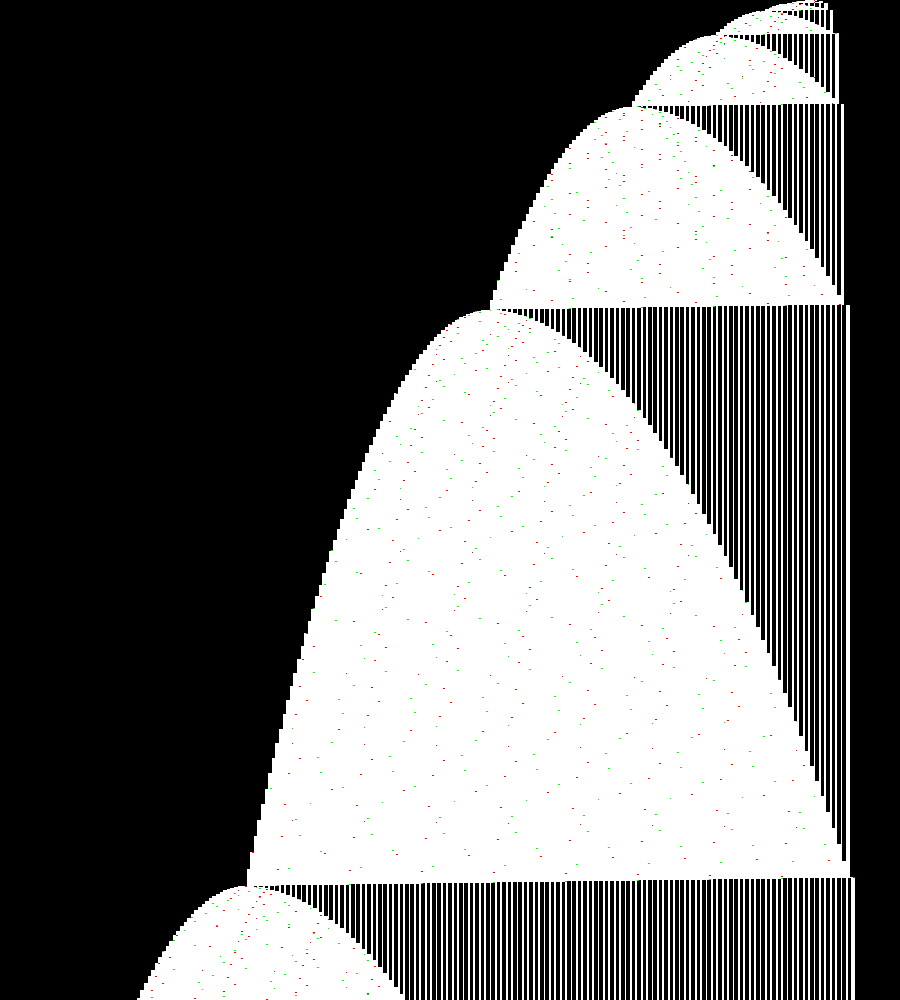

In [16]:
img = tm_trace_to_image(bb5_champion, origin=0.9, width=500, height=40000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Other Halting machines

These were find while running [https://github.com/bbchallenge/bbchallenge-seed](https://github.com/bbchallenge/bbchallenge-seed).

### 40899 steps

In [17]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, C,
		0, R, C, 0, 0, 0,
		1, R, D, 0, R, E,
		1, L, E, 0, R, A,
		0, L, A, 0, L, E]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 40899 steps.")

s    0    1
---  ---  ---
A    1RB  0LC
B    0RC  ???
C    1RD  0RE
D    1LE  0RA
E    0LA  0LE
Halts after 40899 steps.


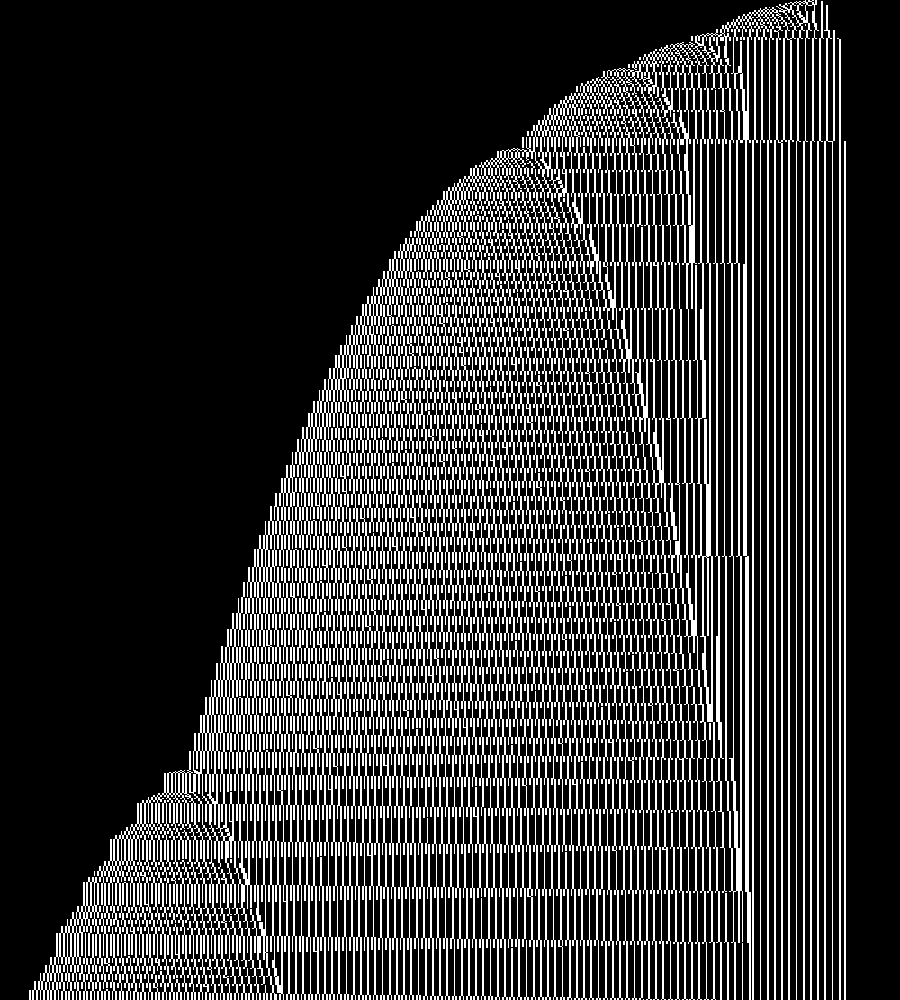

In [18]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=40899).resize((900,1000), Image.NEAREST)
img

### 20739 Steps

In [19]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, A,
		0, R, C, 1, R, D,
		1, L, C, 1, L, A,
		1, R, A, 1, R, E,
		0, 0, 0, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 20739 steps.")

s    0    1
---  ---  ---
A    1RB  0LA
B    0RC  1RD
C    1LC  1LA
D    1RA  1RE
E    ???  0RB
Halts after 20739 steps.


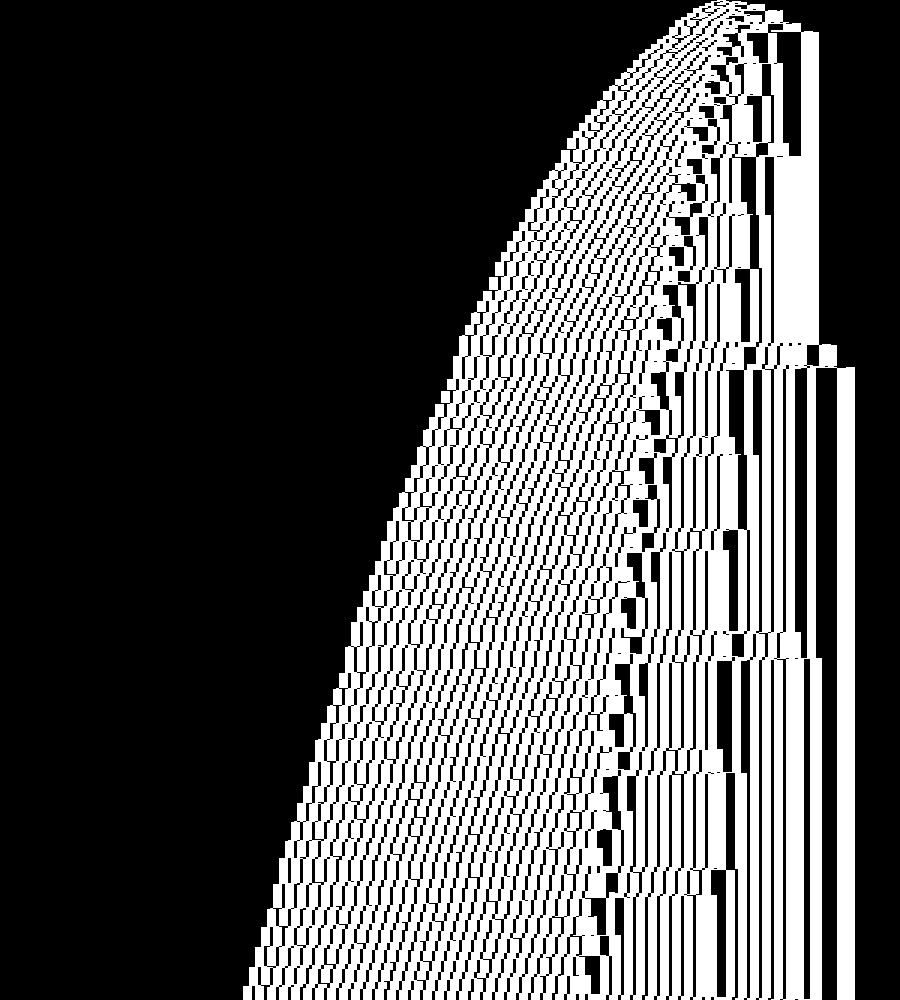

In [20]:
img = tm_trace_to_image(m, origin=0.8, width=300, height=20739).resize((900,1000), Image.NEAREST)
img

### 5309 Steps

In [21]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, R, C, 1, L, E,
		1, L, B, 1, R, D,
		1, R, C, 0, L, A,
		0, 0, 0, 1, L, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 5309 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0RC  1LE
C    1LB  1RD
D    1RC  0LA
E    ???  1LB
Halts after 5309 steps.


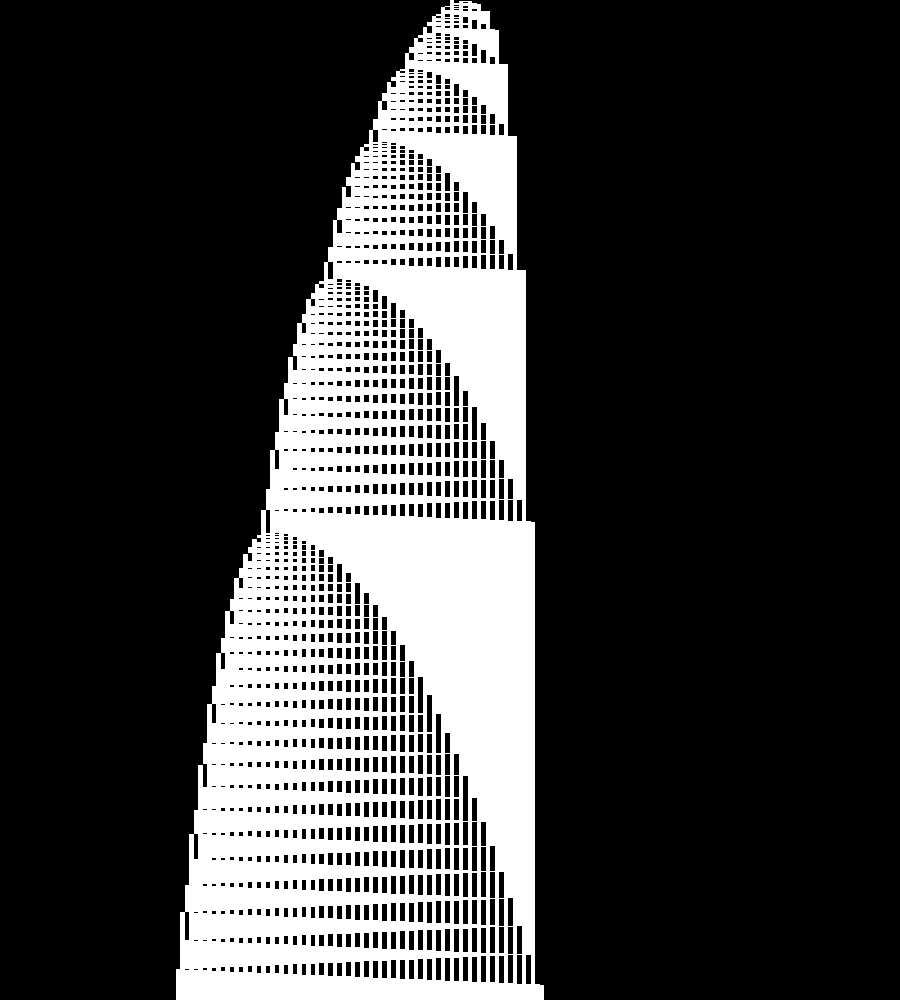

In [22]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=5309).resize((900,1000), Image.NEAREST)
img

### 6987 steps

In [23]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, R, D,
		0, R, C, 1, R, C,
		1, L, A, 0, L, A,
		1, L, C, A, L, E,
		0, 0, 0, 0, L, D]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 6987 steps.")

s    0    1
---  ---  ---
A    1RB  1RD
B    0RC  1RC
C    1LA  0LA
D    1LC  1LE
E    ???  0LD
Halts after 6987 steps.


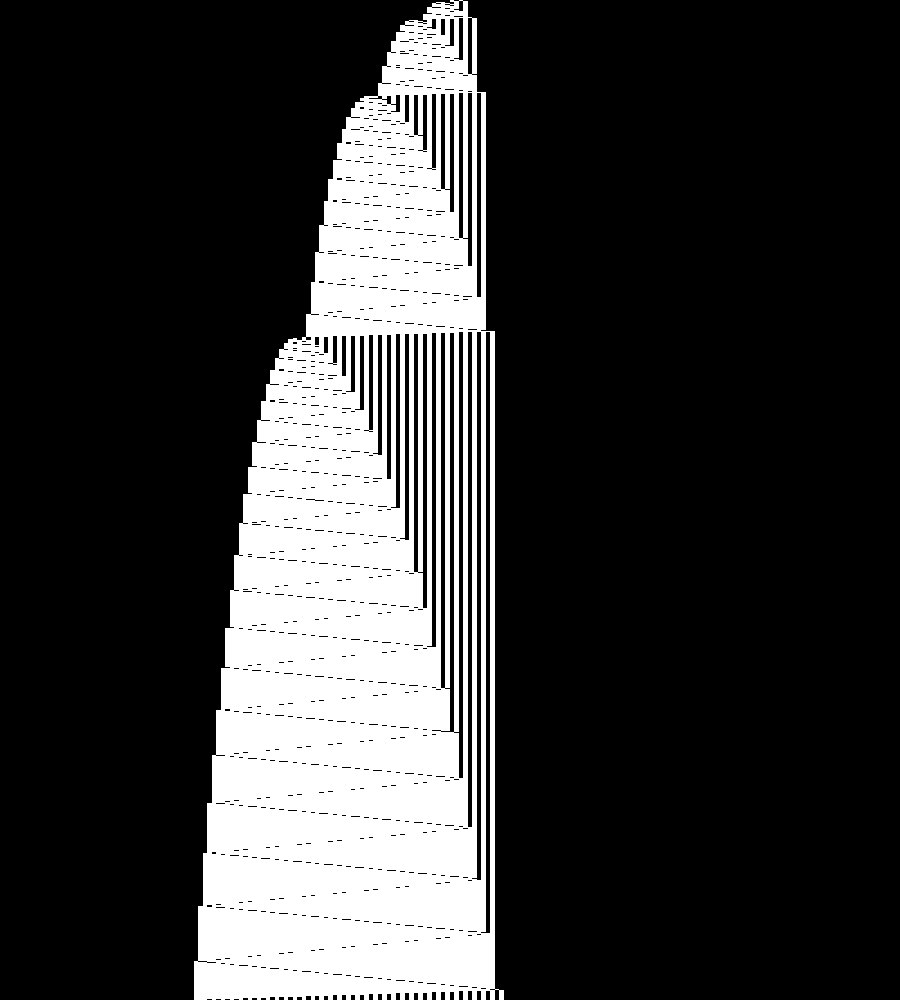

In [24]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=6987).resize((900,1000), Image.NEAREST)
img

### 22335 steps

In [25]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, L, B, 1, R, C,
		1, L, D, 0, L, E,
		1, R, E, 1, L, C,
		0, 0, 0, 0, R, A]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 22335 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0LB  1RC
C    1LD  0LE
D    1RE  1LC
E    ???  0RA
Halts after 22335 steps.


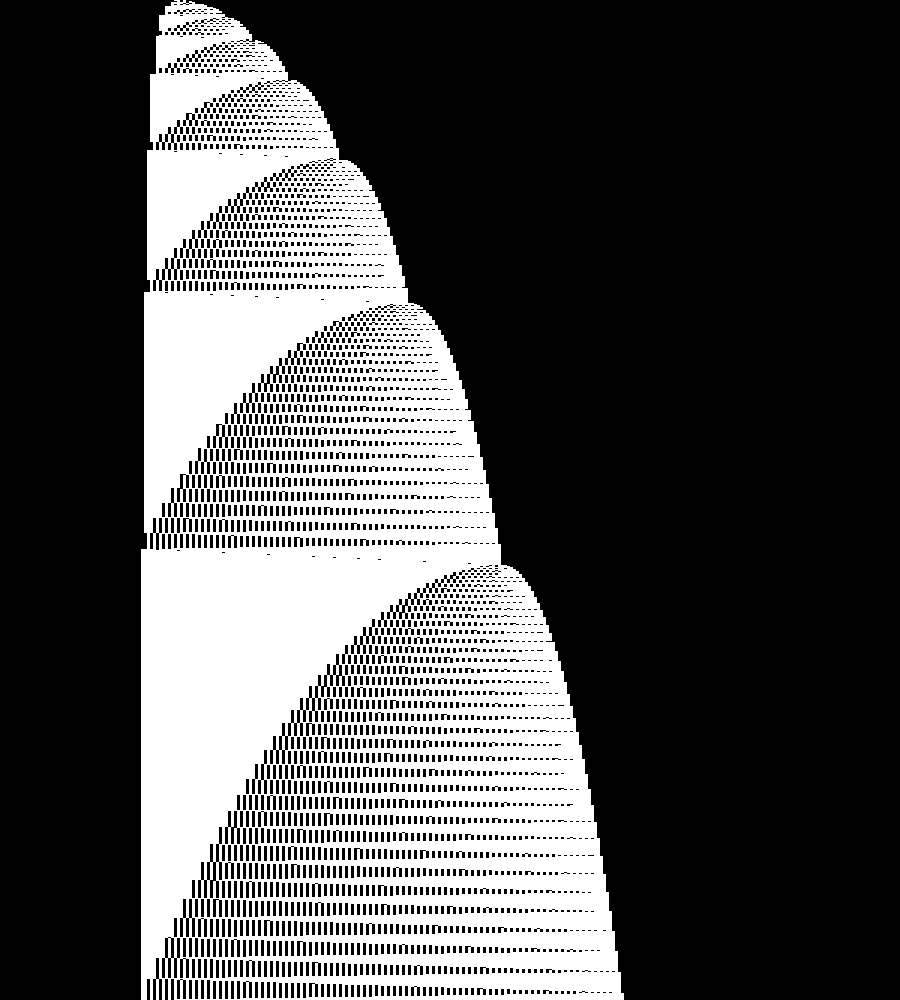

In [26]:
img = tm_trace_to_image(m, origin=0.2, width=300, height=22335).resize((900,1000), Image.NEAREST)
img

### 2133492 steps

In [27]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, C,
		0, L, A, 0, L, D,
		1, L, A, 0, 0, 0,
		1, L, B, 1, R, E,
		0, R, D, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 2133492 steps.")

s    0    1
---  ---  ---
A    1RB  1LC
B    0LA  0LD
C    1LA  ???
D    1LB  1RE
E    0RD  0RB
Halts after 2133492 steps.


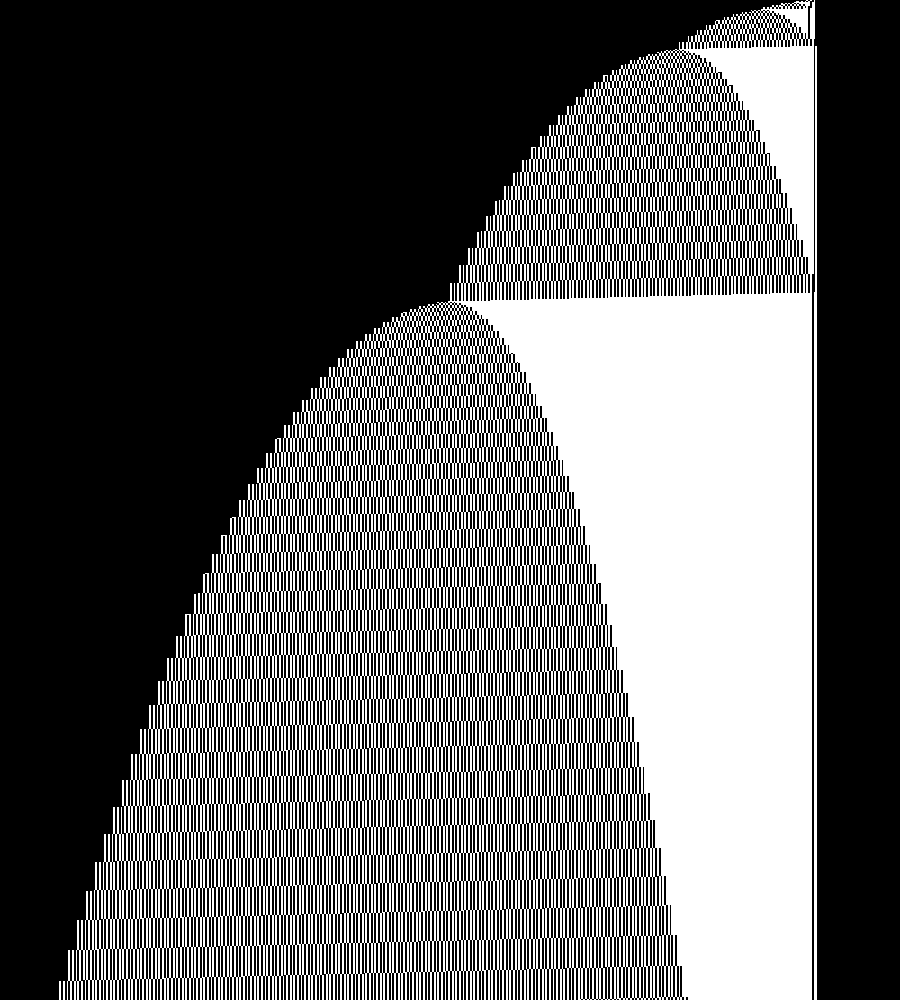

In [28]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=22335).resize((900,1000), Image.NEAREST)
img

## "Chaotic" machine

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [29]:
R, L = 0, 1
chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		1, L, 0, 0, L, 3]
chaotic_machine = repr_to_bytes(chaotic_machine_rep)
pptm(chaotic_machine)

s    0    1
---  ---  ---
A    1LB  1RB
B    1RC  0LE
C    0RD  0LA
D    1LA  0RD
E    ???  0LC


In [30]:
R, L = 1, 0
sym_chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		0, 0, 0, 0, L, 3]
sym_chaotic_machine = repr_to_bytes(sym_chaotic_machine_rep)
pptm(sym_chaotic_machine) 
print("This is machine n = 67279052")

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC
This is machine n = 67279052


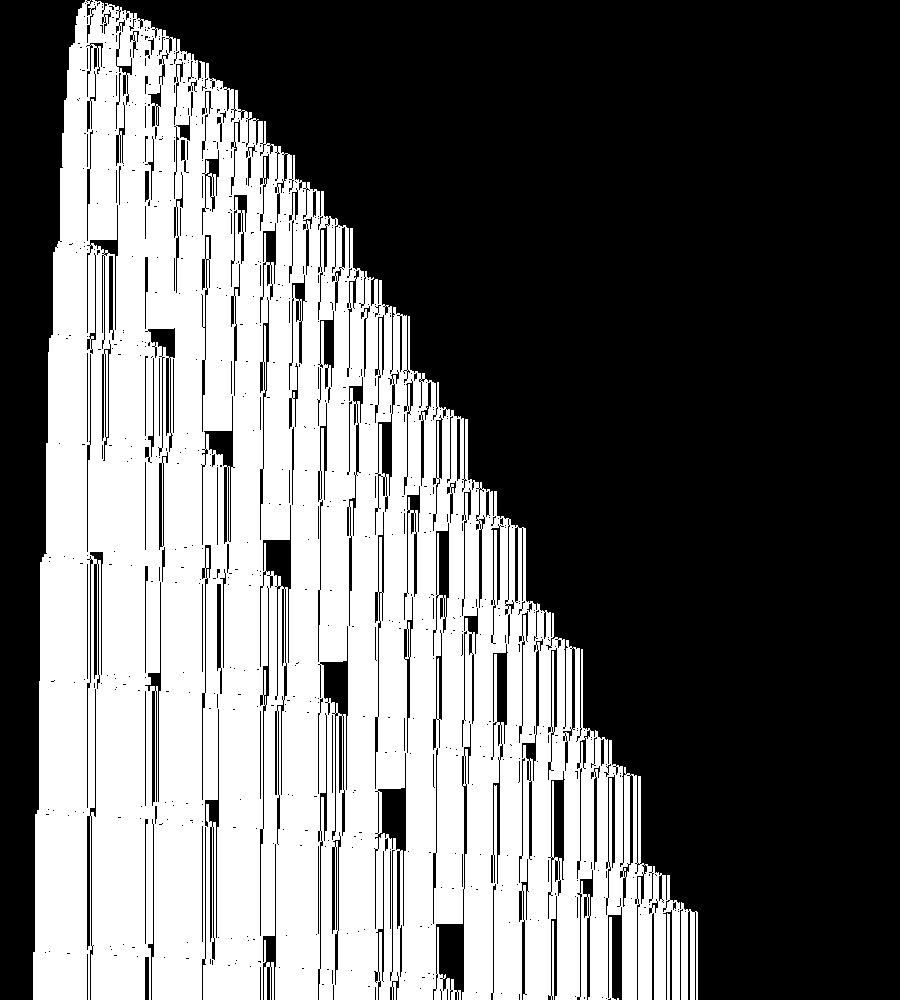

In [31]:
img = tm_trace_to_image(sym_chaotic_machine, origin=0.1, width=1000, height=100000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## "Complex counter"

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [32]:
R, L = 0, 1
complex_counter_rep = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 1, L, 0]
complex_counter = repr_to_bytes(complex_counter_rep)
pptm(complex_counter)

s    0    1
---  ---  ---
A    1LB  1RA
B    0RA  0LC
C    0RC  1LD
D    1LE  0RA
E    0LB  ???


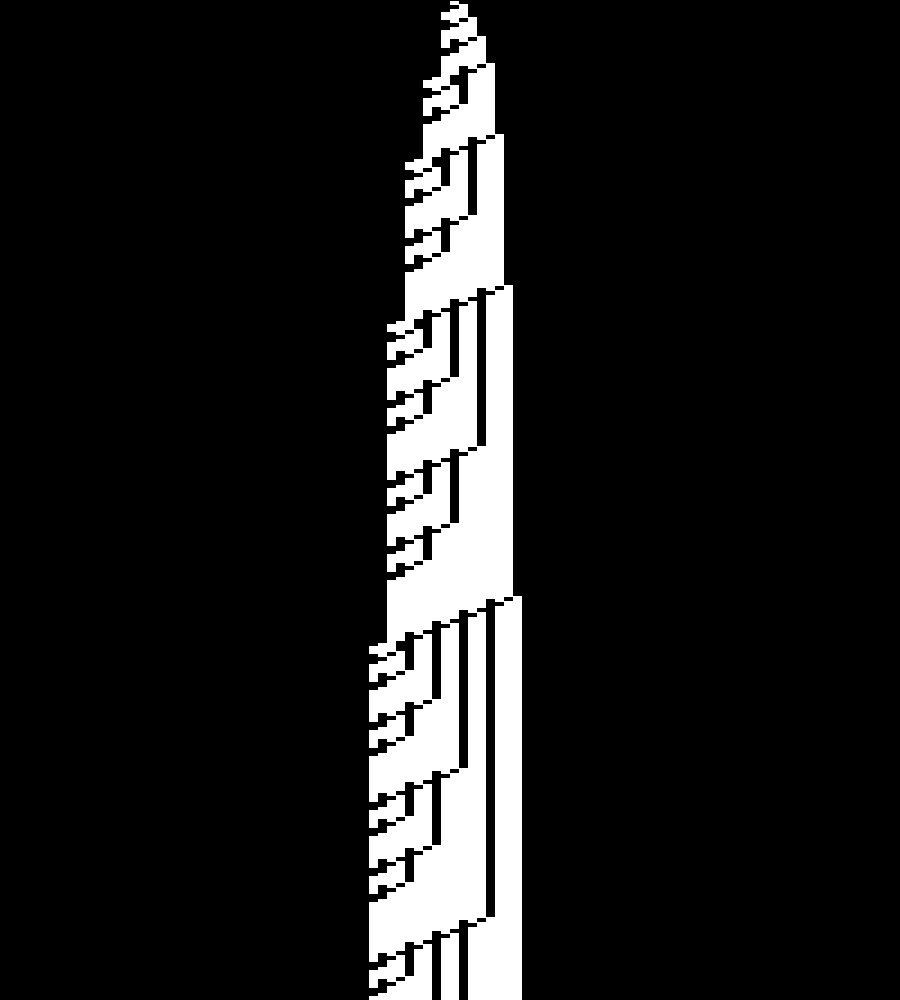

In [33]:
img = tm_trace_to_image(complex_counter, origin=0.5, width=100, height=1000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Random machine

In [34]:
n_history = []

55884290
s    0    1
---  ---  ---
A    1RB  1LE
B    1RC  ???
C    1LD  1LE
D    1RD  1LA
E    1RE  0RC


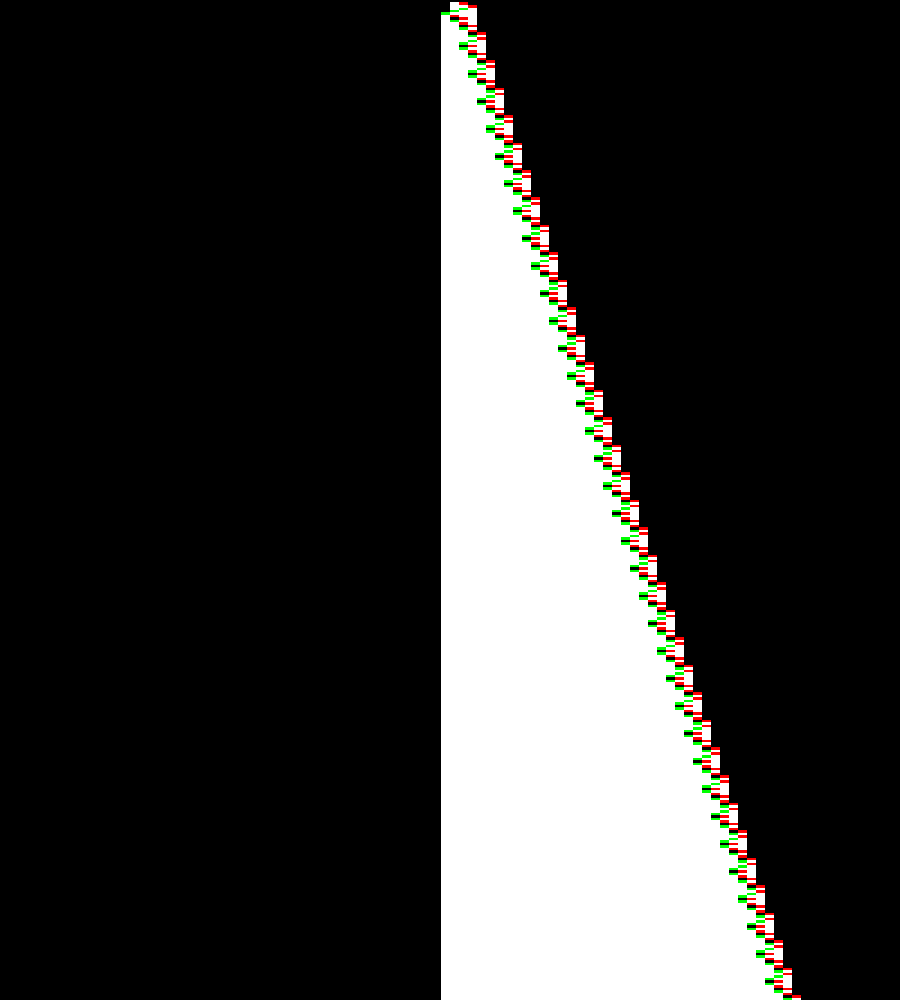

In [100]:
n = random.randint(0,undecided_total-1)
n_history.append(n)

print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Undecided Index

Available for download: [https://dna.hamilton.ie/tsterin/bb5_undecided_index](https://dna.hamilton.ie/tsterin/bb5_undecided_index)   
Shasum: `68830ed2ba8f249a521586cf9f6230a09dd8bc7c`

In [209]:
UNDECIDED_INDEX_PATH= "bb5_undecided_index"
UNDECIDED_FILE_SIZE = os.path.getsize(UNDECIDED_INDEX_PATH)
UNDECIDED_FILE_SIZE

9295144

In [210]:
undecided_index = []
with open(UNDECIDED_INDEX_PATH, "rb") as f:
    for i in range(UNDECIDED_FILE_SIZE//4):
        chunk = f.read(4)
        undecided_index.append(int.from_bytes(chunk, byteorder="big"))

In [211]:
len(undecided_index)

2323786

In [212]:
undecided_time

14322029

In [213]:
undecided_time_index = []
undecided_space_index = []
for i in undecided_index:
    if i < undecided_time:
        undecided_time_index.append(i)
    else:
        undecided_space_index.append(i)
print(len(undecided_time_index), len(undecided_space_index))

1954418 369368


In [214]:
def is_sub_machine(m,m1):
    """ m sub machine of m1"""
    for i in range(len(m)//3):
        if m[3*i+2] == 0:
            continue
        for j in range(3):
            if m[3*i+j] != m1[3*i+j]:
                return False
    return True

# Looking for Chaotic machine

In [202]:
def getMachineID(m, indexToLookOutFrom, printSubMachines=False):
    for i in indexToLookOutFrom:
        m2 = get_machine_i(DB_PATH,i)
        if m2 == m:
            return i
        if is_sub_machine(m2,m) and printSubMachines:
            print(i)
            pptm(m2)
    print("Not found")
    return None

In [203]:
pptm(sym_chaotic_machine)

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC


In [204]:
getMachineID(sym_chaotic_machine,undecided_space_index)

67279052

# Random Undecided Machine

In [215]:
n_history = []

10214099


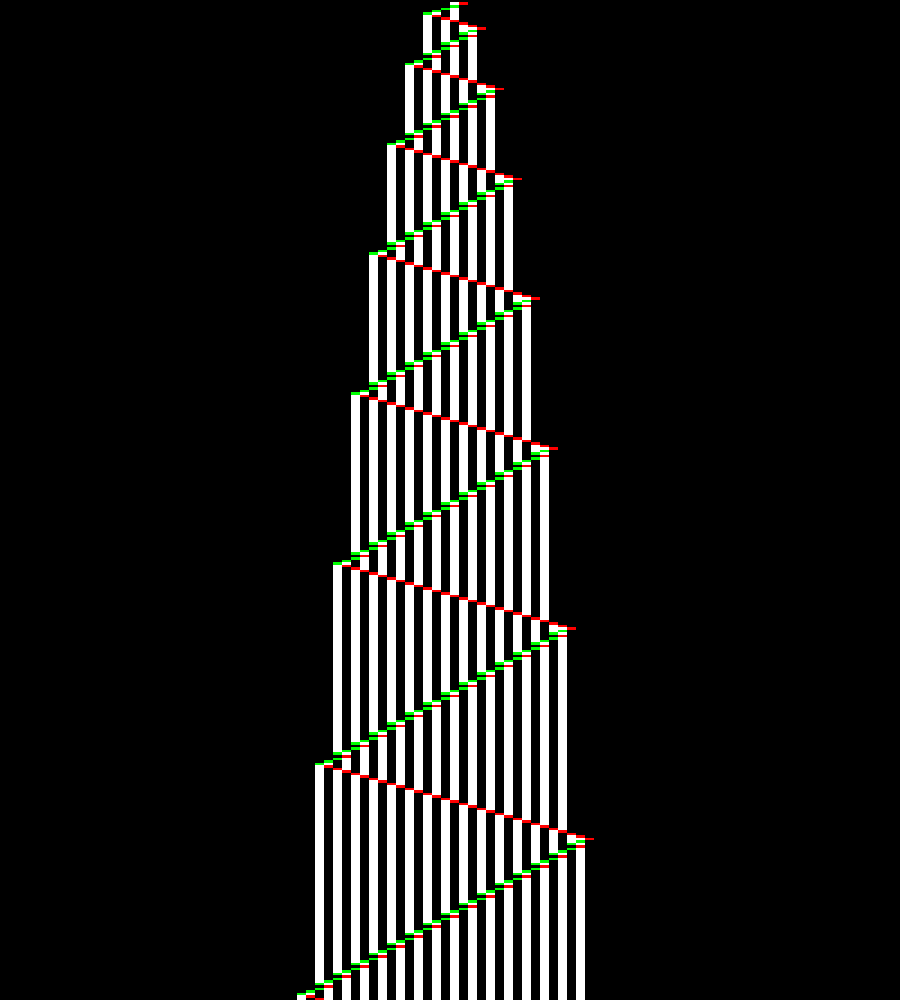

In [218]:
n = random.choice(undecided_index)
n_history.append(n)
print(n)
#pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## List of random undecided machines for speedy lookin

7911387


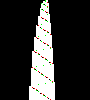

9868918


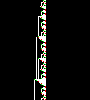

1706758


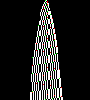

8108602


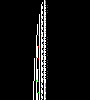

11398522


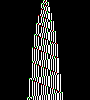

8771675


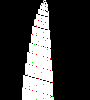

3468084


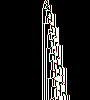

82149073


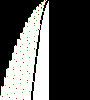

9999692


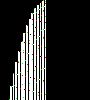

10749062


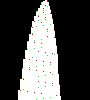

8080128


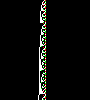

6975450


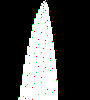

7779767


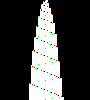

24277797


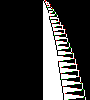

13156392


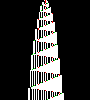

7594386


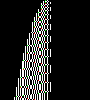

8779213


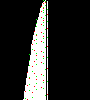

5449277


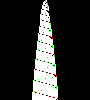

12107561


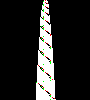

11690121


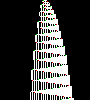

9427774


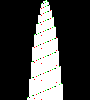

48911922


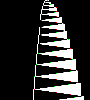

3050114


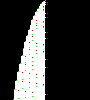

1702924


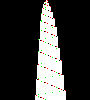

4107132


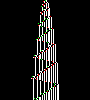

51033363


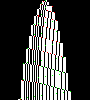

10433938


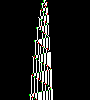

7400130


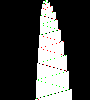

80409


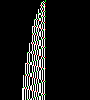

7498329


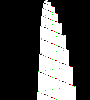

43312158


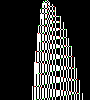

11512803


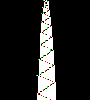

9267155


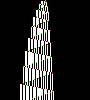

3337888


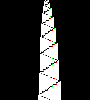

7062892


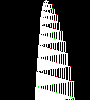

13540151


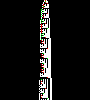

30842423


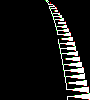

3973754


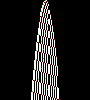

350586


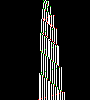

4315097


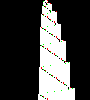

1345575


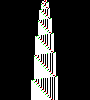

11118244


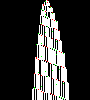

13895297


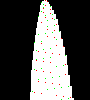

8260924


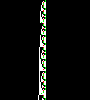

10926120


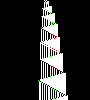

56939170


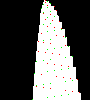

13945319


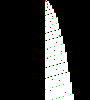

4664551


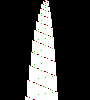

7269113


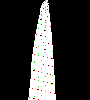

374971


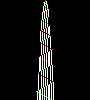

5047491


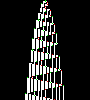

49630454


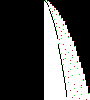

32026524


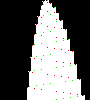

8457305


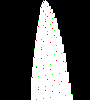

12361307


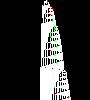

4037589


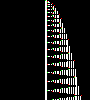

6190578


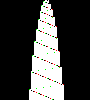

4932394


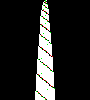

11393394


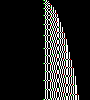

4701099


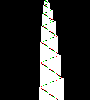

48473825


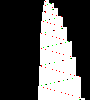

8052067


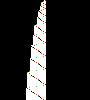

2216951


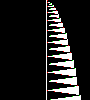

10551192


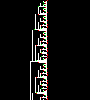

12243309


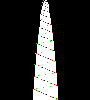

1941156


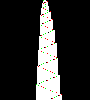

11751270


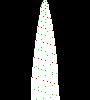

8357476


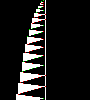

7103300


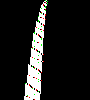

13936786


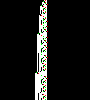

2255127


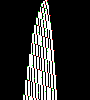

453898


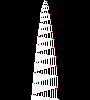

12420969


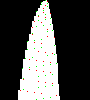

522867


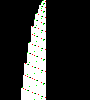

5900002


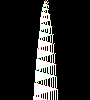

5897497


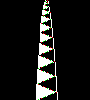

583125


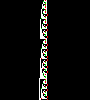

1050130


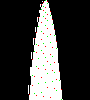

11617676


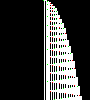

1131040


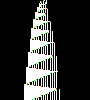

4813870


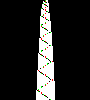

489854


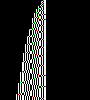

6975172


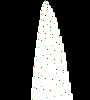

10870725


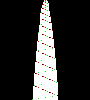

7108217


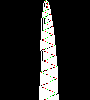

1251256


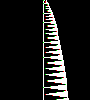

1026354


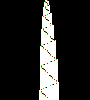

7204097


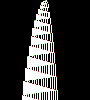

14173411


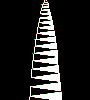

9852795


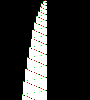

80932357


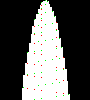

7020613


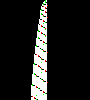

4215488


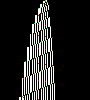

1717587


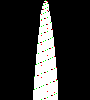

6170171


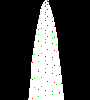

7743798


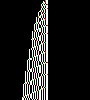

13086064


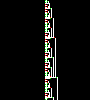

13783161


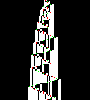

1425419


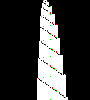

5501253


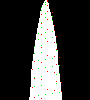

78527332


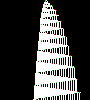

12079351


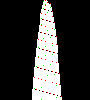

13123269


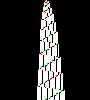

13255568


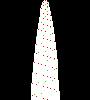

7718203


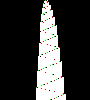

728634


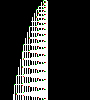

9978106


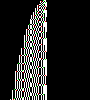

47495566


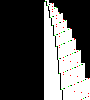

8688935


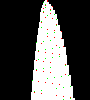

4246283


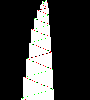

8891963


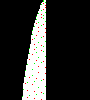

8909825


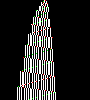

1695868


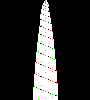

12573053


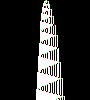

9836102


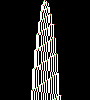

6781621


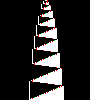

72647616


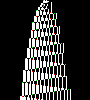

10135117


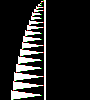

75429538


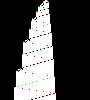

60125508


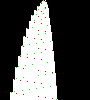

35938392


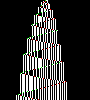

6309160


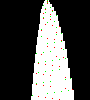

4682983


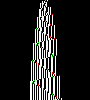

7846781


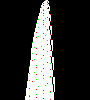

5320601


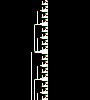

12179253


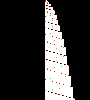

9390855


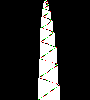

86683623


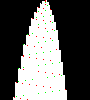

6072147


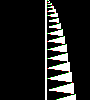

6919546


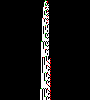

8195998


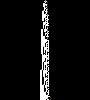

1962405


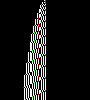

87139198


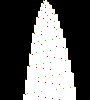

5078454


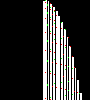

14053482


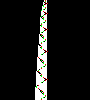

3162369


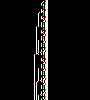

7213441


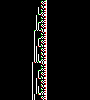

4933314


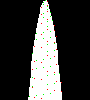

7823138


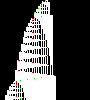

83428956


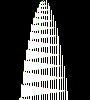

11481625


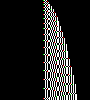

48457650


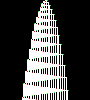

91260


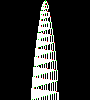

40170936


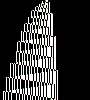

1283867


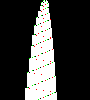

550191


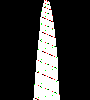

11804860


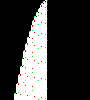

11102787


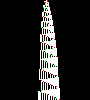

2473427


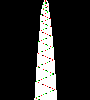

55425668


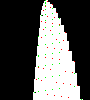

6270772


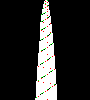

13602649


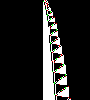

480005


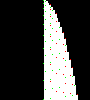

6562664


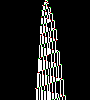

10936475


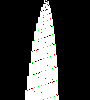

73781766


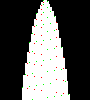

9617984


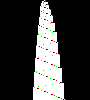

639363


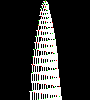

29568377


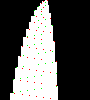

11436895


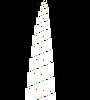

6811730


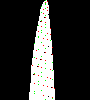

4646569


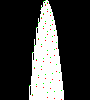

13744230


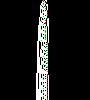

8660593


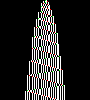

9510658


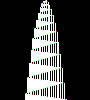

8851602


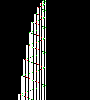

10025581


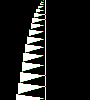

83658


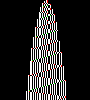

10300084


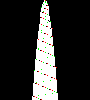

43390210


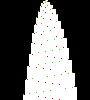

21185545


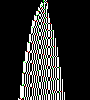

13822543


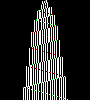

9879305


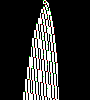

8778372


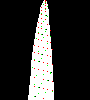

5057514


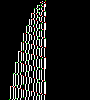

13369860


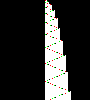

3232711


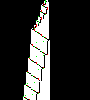

50997963


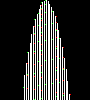

13300410


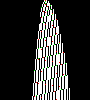

27486


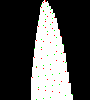

14117454


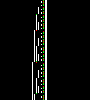

11394126


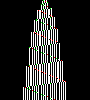

1362743


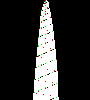

36786


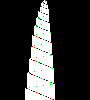

13565921


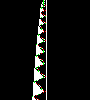

7240727


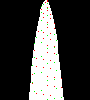

2237777


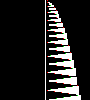

2194868


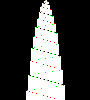

4829898


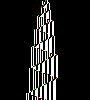

13999727


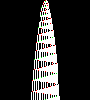

14111194


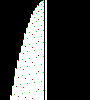

21873028


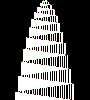

9446709


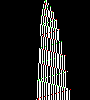

12383786


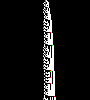

11437380


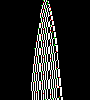

13950692


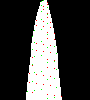

2152316


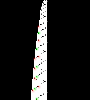

14260557


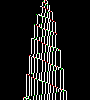

7271677


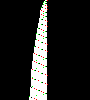

6751157


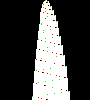

In [219]:
for _ in range(200):
    n = random.choice(undecided_index)
    print(n)
    #pptm(get_machine_i(DB_PATH,n))
    img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=800, show_head_direction=True).resize((90,100), Image.NEAREST)
    display(img)

### Temporary machine which was under scrutiny

9241691
s    0    1
---  ---  ---
A    1RB  ???
B    0LC  1RD
C    1LC  1RD
D    0RE  0RD
E    1LB  1LE


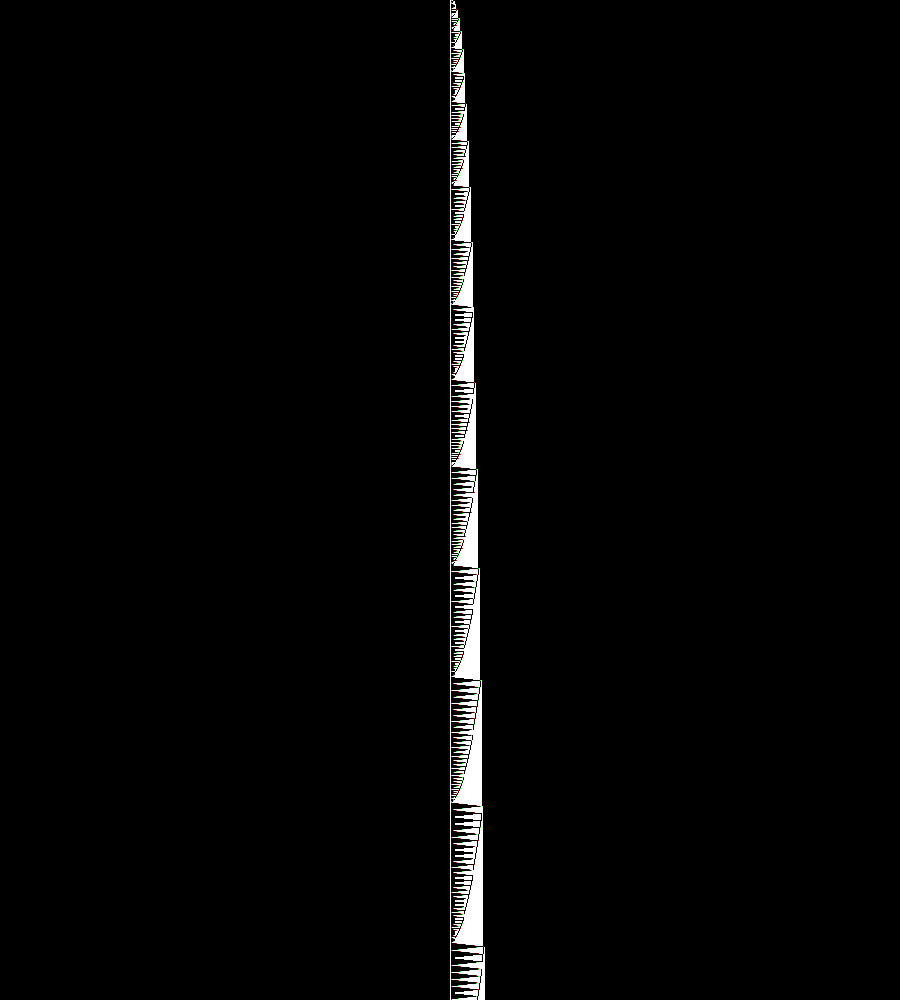

In [259]:
n = 9241691#11118244
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=1000, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Zoology

## Cyclers

**Update 28/01/22**. 11 229 238 cyclers were decided (among machines that exceeded time limit) thanks to this decider: [https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers).

13551915
s    0    1
---  ---  ---
A    1RB  0RB
B    1LC  1RC
C    0LD  0LD
D    1RE  1LA
E    1RD  ???


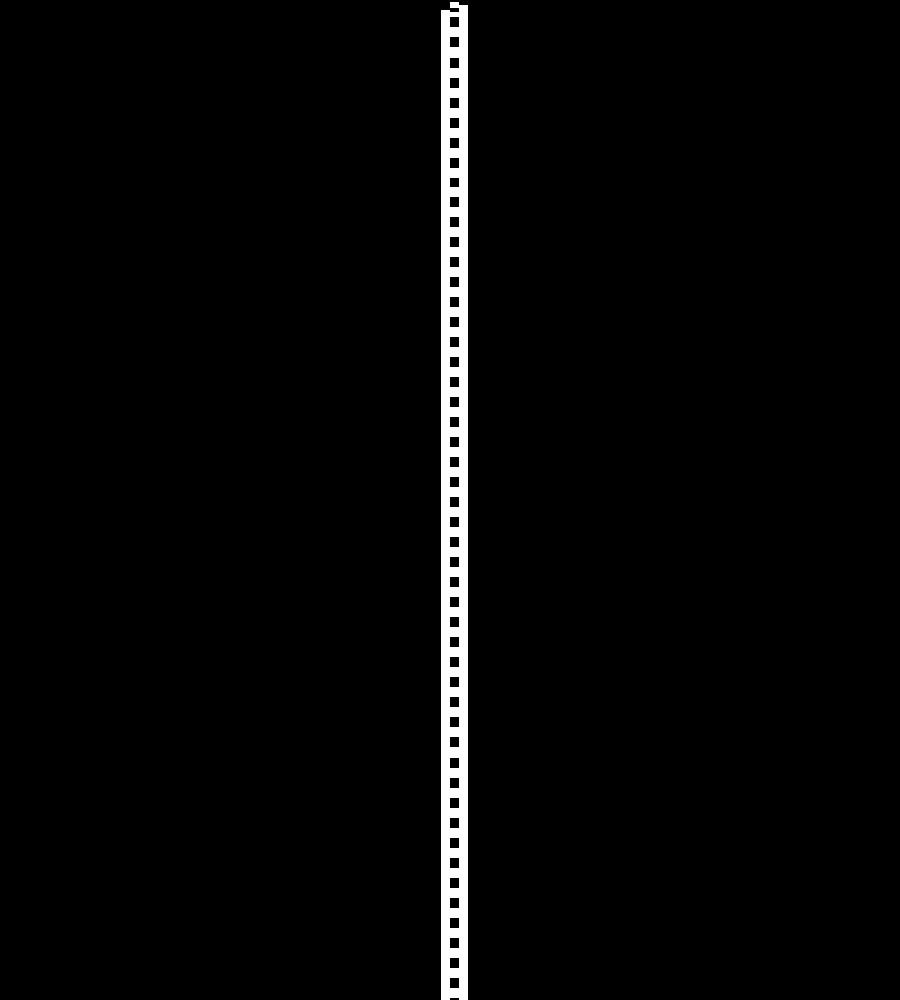

In [49]:
n_list = [5164457,13551915,4888229]
n = random.choice(n_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Stairs / Translated Cyclers

**Update 29/01/22**. 73 857 622 translated-cyclers were decided (among machines that exceeded space limit) thanks to the translated-cyclers decider:
[https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers).

In [50]:
pptm(get_machine_i(DB_PATH,188))

s    0    1
---  ---  ---
A    1RB  1LA
B    0LA  1RC
C    1RA  0RD
D    1LE  0LE
E    1LB  ???


73643020


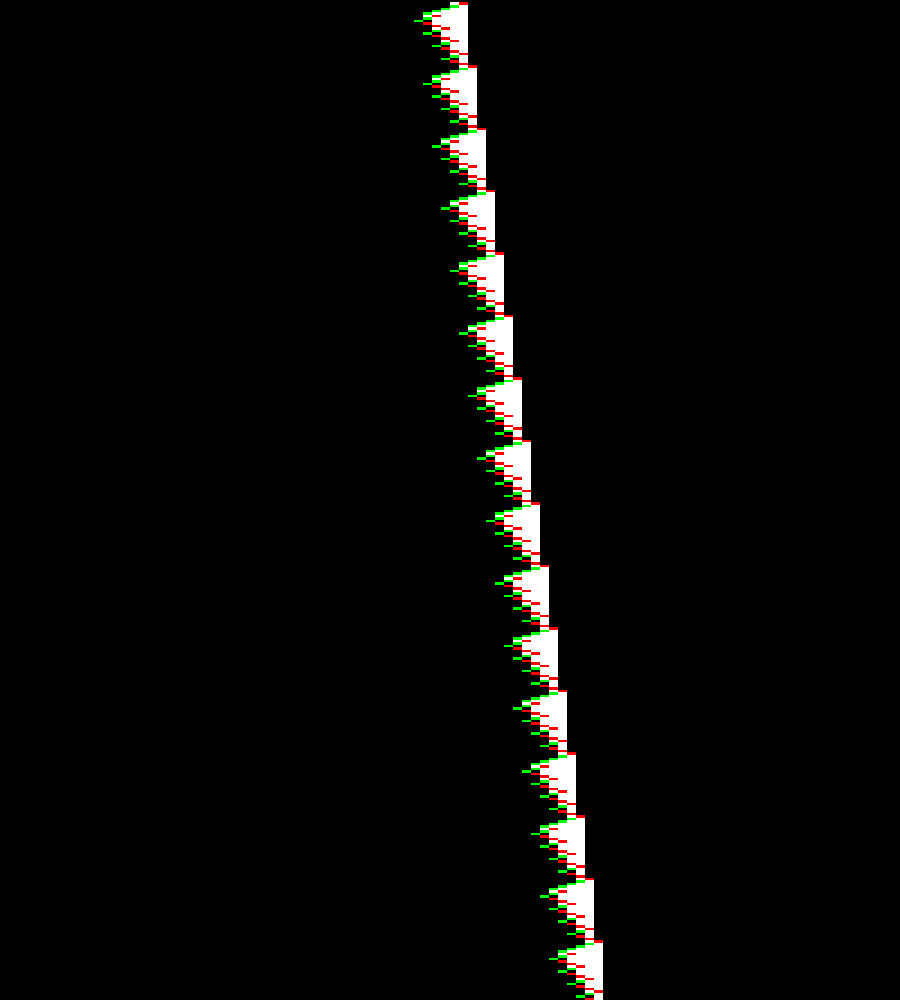

In [101]:
n_list = [78619822,52297459,37549149,37799884,33613794,65712201,73643020,73823886,87711504]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Unilateral Pongs

13930014


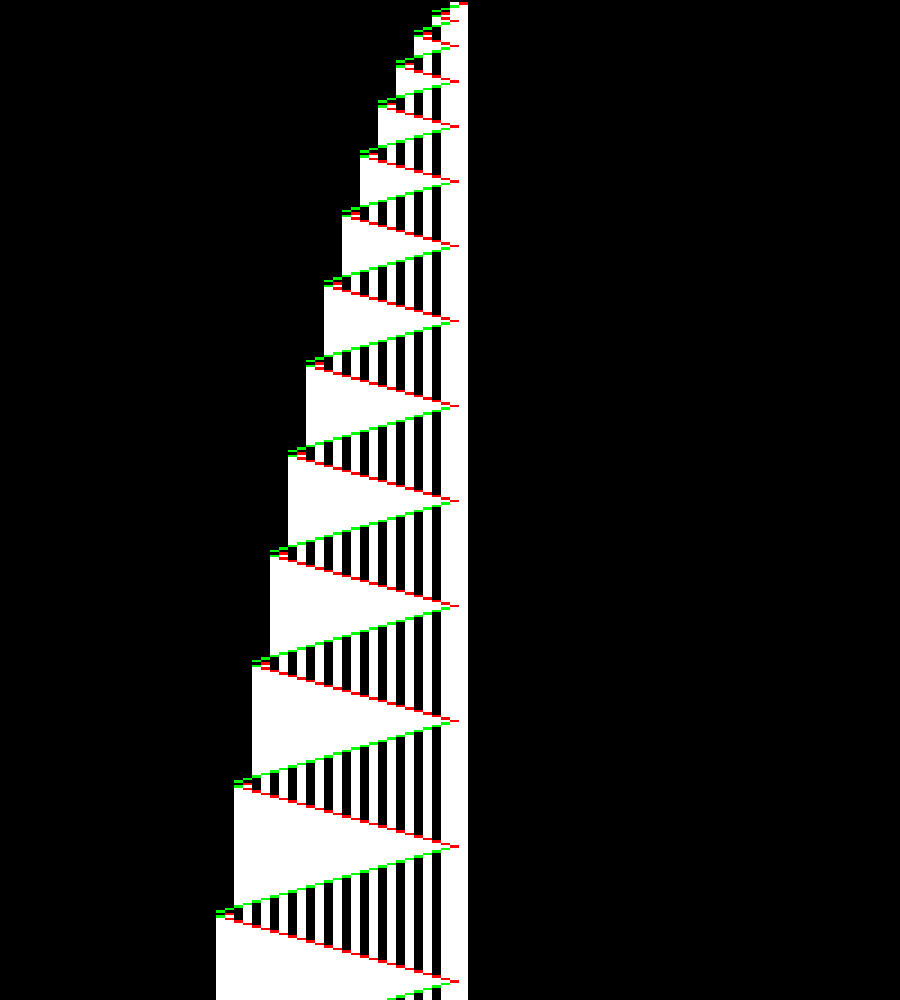

In [117]:
unilateral_pongs_list = [5643626, 3565349, 2108244, 13474013, 9755023, 8103390, 9225630, 3169967, 
                         10363739, 12223654, 13090023, 11225780, 11544059, 1507193, 13795582, 12244006, 
                         13930014, 11334525, 1028021, 1566023, 269038, 828479, 8497788, 6136947, 11635490, 6398375, 
                         9703986, 5203553, 6843551, 6964220, 11598427, 13576089, 11519070, 9913985, 11916339] + [9241691]
n = random.choice(unilateral_pongs_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Translated Unilateral Pongs

10613000


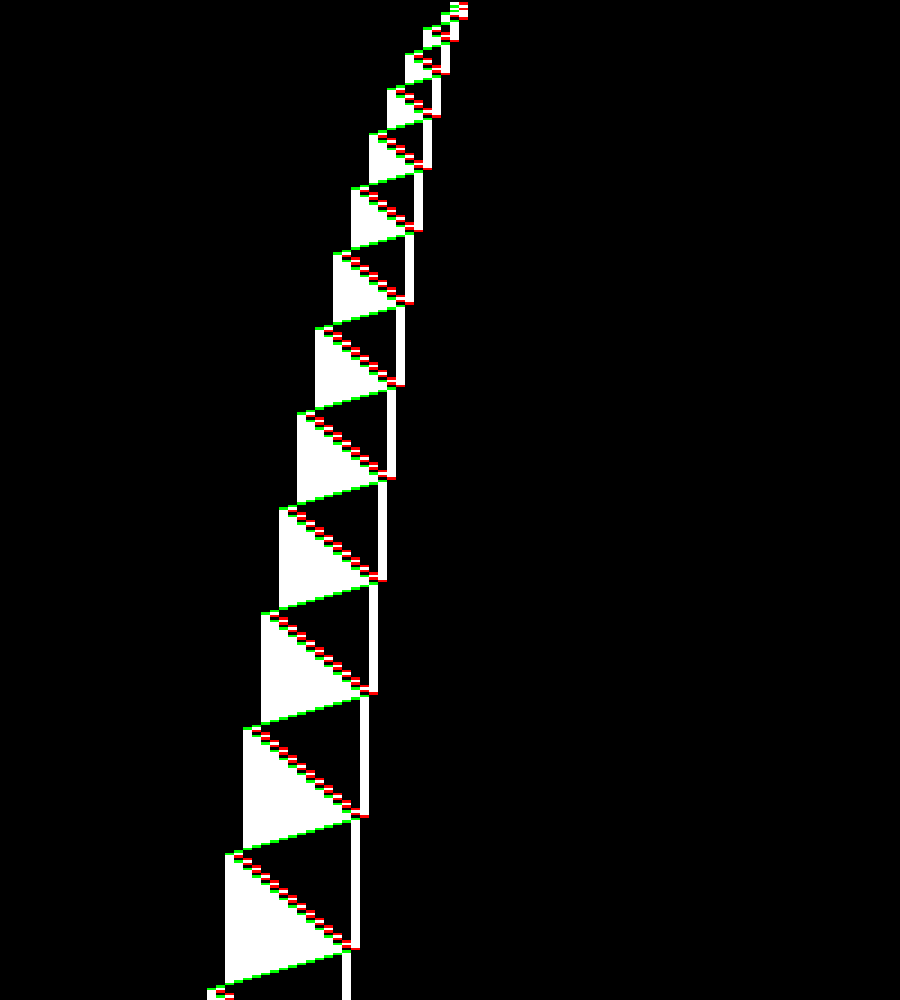

In [509]:
translated_unilateral_pongs_list = [4824149,47437564,7431789,10613000]
n = random.choice(translated_unilateral_pongs_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Bilateral Pongs

6399980


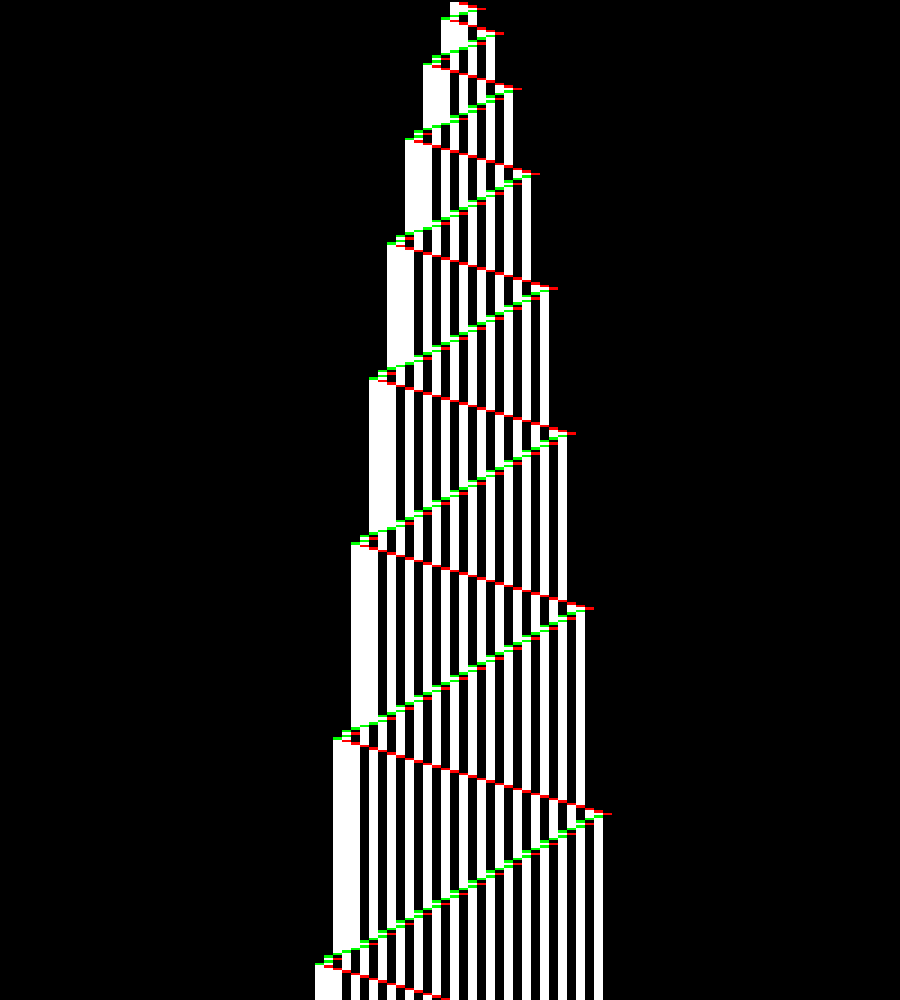

In [147]:
bilateral_pongs_list = [14086216, 8439154, 87940465, 11089226, 4482180, 4284, 4468110, 12189145, 
                        12206912, 46840666, 8416617, 13440160, 2498135, 12285970, 14218336, 8634375, 1048062, 
                        13977714, 8457777, 4745553, 1153972, 13802273, 11388271, 5383040, 1507193, 9786806, 5702127, 
                        7883753, 4557119, 33672339, 3370060, 402959, 11515638, 6399980, 1960734, 8818662, 6300366, 8900440, 
                        6092203, 11980798, 9813712, 4058620, 3418516, 14044691, 9312210, 172282, 582211, 12199575, 12594284, 
                        2731122, 7716308, 12292720, 12549707, 26414953, 2479142, 6152467, 38111044, 662317, 526738, 5328524, 
                        13649989, 4208656, 13784545, 5928209, 5532891, 12876855, 937083, 4726380, 67780089, 13104130, 1015814, 
                        12215361, 76952003, 205766, 13394264, 13810851, 11746917, 24345867, 9551409, 5292000, 3648846, 13676337, 64805436, 
                        619693, 11069776, 12838991, 9115769, 12558695, 13301056, 12160685, 12301430, 1051485, 4023683, 33427945,11460162,6389200,8414269]

                        + [4859453,4105843]
n = random.choice(bilateral_pongs_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Smart Counters

4807678


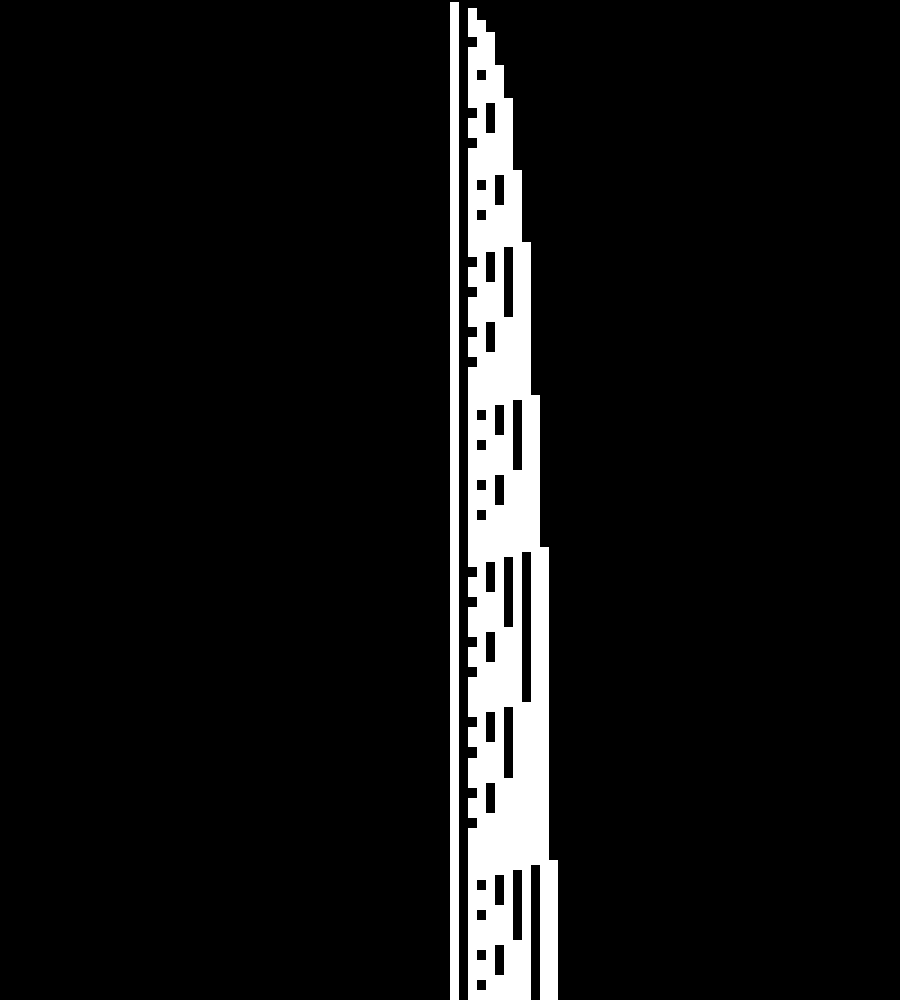

In [89]:
smart_counters = [11184382, 7931183, 7695094, 8594059, 12877334, 4631164, 
                  4807678, 467941, 11776032, 12345394, 1236862, 14009904, 12418684, 10269203]
n = random.choice(smart_counters)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Potential Halters

54221304
s    0    1
---  ---  ---
A    1RB  0LE
B    1RC  1RB
C    1LD  1RA
D    1LB  1LD
E    ???  0RB


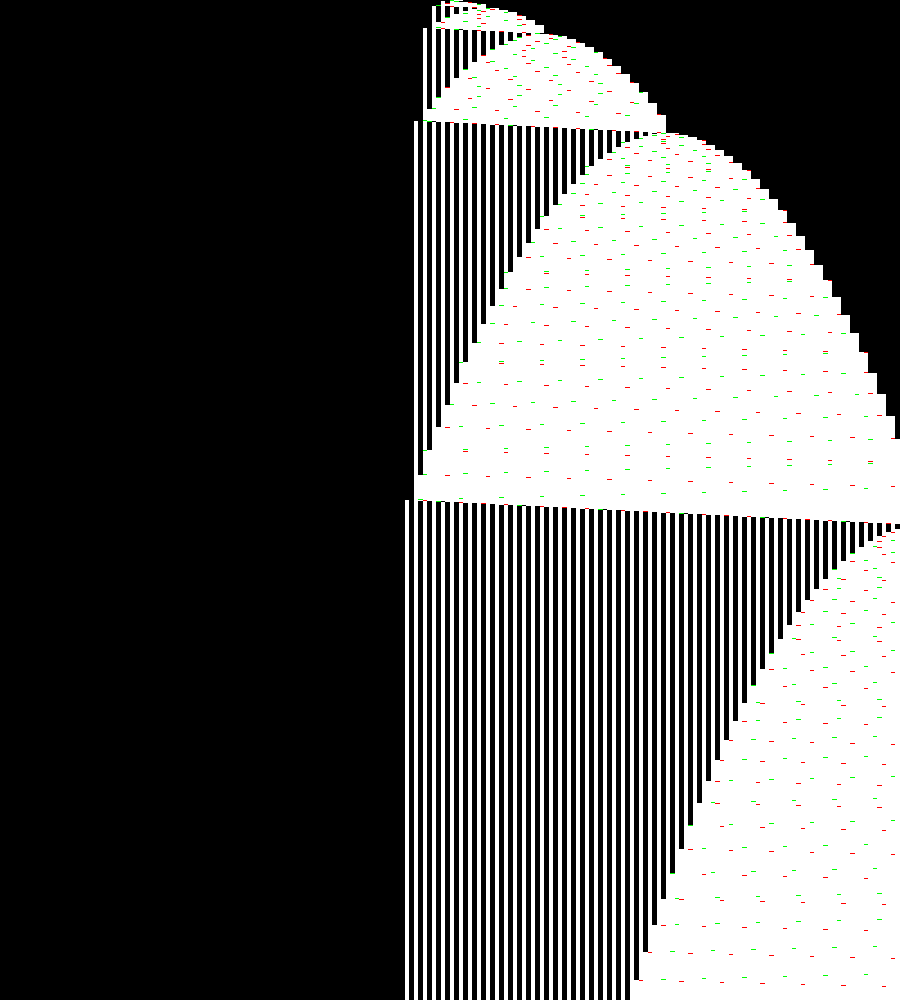

In [173]:
potential_halters_list = [40851850,54221304,11710205,11726152,72903966,10039500,7850055,4966400] + [13754164,7658575] 
# ^ they are all looking a lot like BB5 apart from 13754164 that looks like 20739 steps, 7658575 as well
n = random.choice(potential_halters_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=9000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Not classed yet

11836695


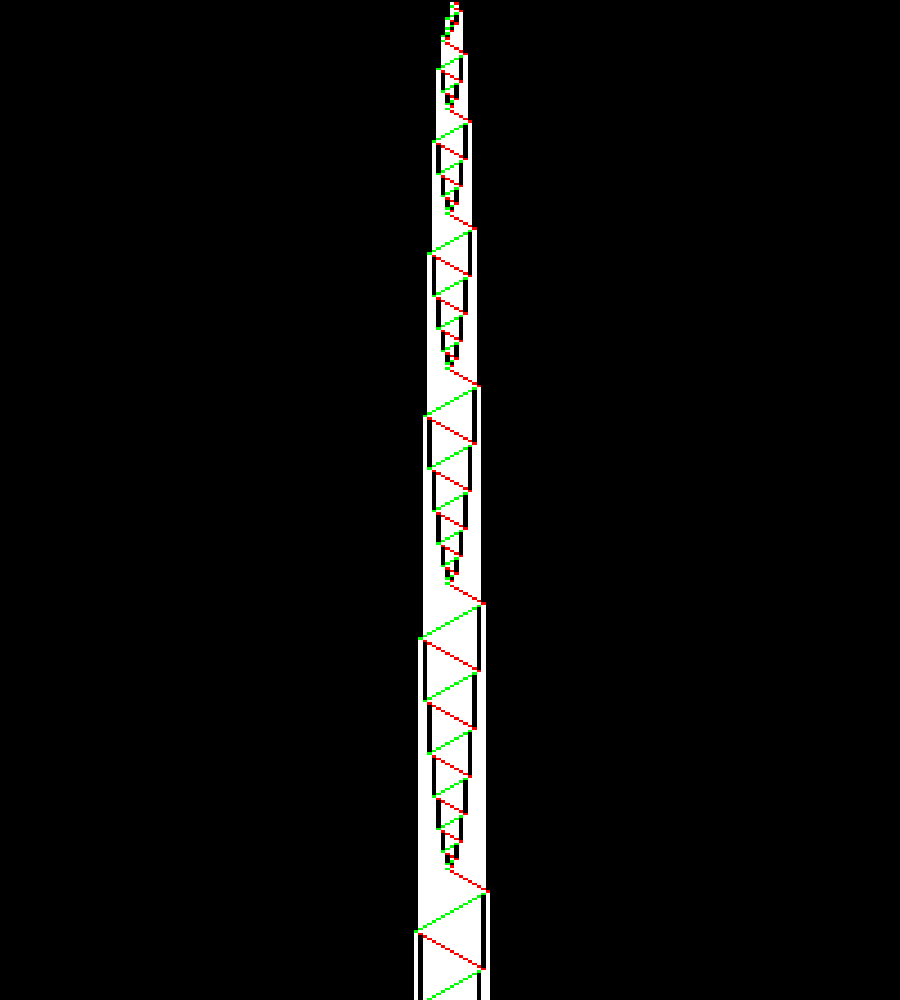

In [181]:
n_list = [12822179,8928979,11533877,3155816,40851850,6196993,7381867,11836695,12068115,6610221]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Funny/unrelevant

In [58]:
n_xmas = [5792740,5404086]
bilateral_binary_counter = 2360223

## Backward Reasoning

**Update 09/02/22**. 1 253 418 machines were decided thanks to the backward-reasoning decider:
[https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-backward-reasoning](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-backward-reasoning). As of this day there remains **2 323 786** undecided machines in the database.

Independtly of the behavior of a machine you can sometimes tell that it doesnt halt by simulating it backwards from undefined transitions and realising that it always lead to a contradiction. Example:

7850055
s    0    1
---  ---  ---
A    1RB  ???
B    1RC  1RB
C    1LD  0LE
D    0RB  0LC
E    1RE  1RD


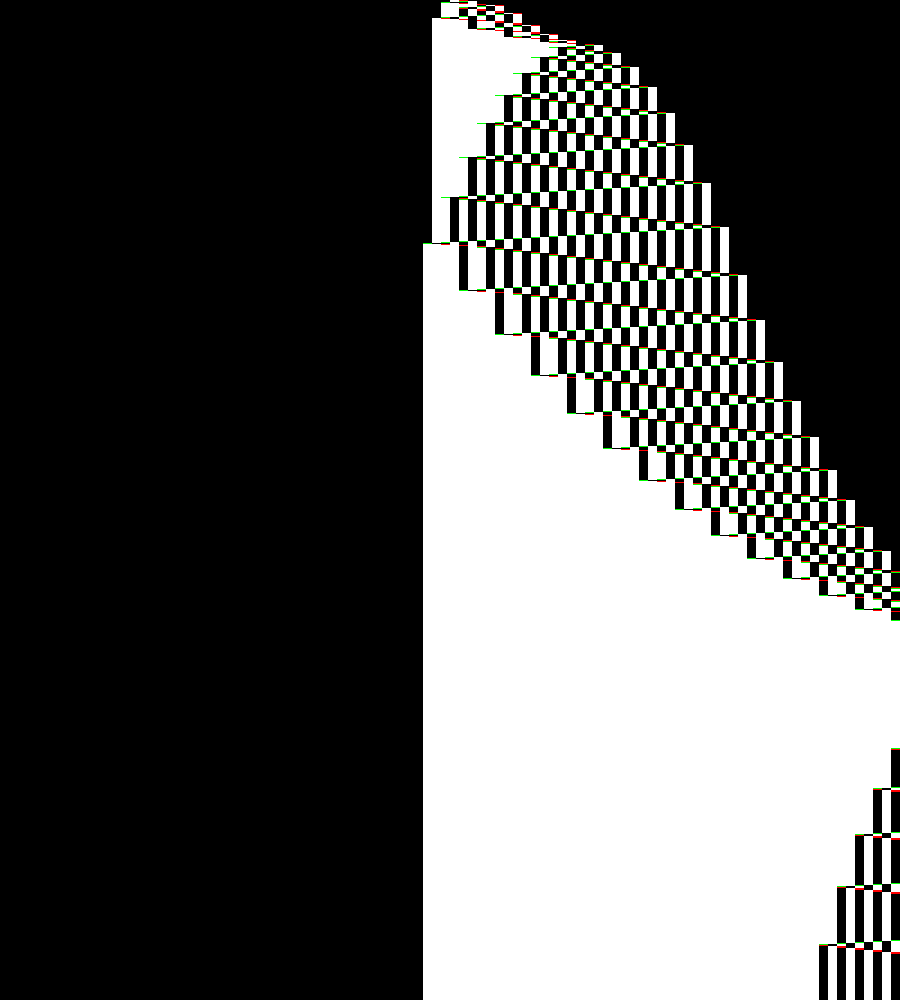

In [208]:
n_backward_reasoning_list = [13955979, 54221304, 7850055, 7658575, 7274055, 620647, 392407] 
n = random.choice(n_backward_reasoning_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=2000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img